In [50]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd

%matplotlib inline

In [51]:
sns.set_theme()

In [52]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')

In [65]:
env_name = 'cartpole'
plot_posterior_returns = False

In [66]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'MBRL': 'default_2021-08-16/16-03-38',
         'SAC': 'sac_pendulum_2021-08-31/10-25-17/',
         'TD3': 'td3_pendulum_2021-08-31/16-43-52/',
         'PPO': 'ppo_pendulum_2021-08-31/12-20-16/',
         'PETS': 'pets_pendulum_2021-09-06/15-03-19/',
         'Changed BAC': 'changed_pend_bac_2021-09-06/14-15-52/',
         'BAC (trig)': 'trig_pendbac_2021-09-07/09-22-04/',
        }

In [76]:
cartpole_paths = {
         'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         'MBRL': 'cartpole_multistart_mbrl_2021-08-18/23-45-13/',
         'SAC': 'sac_cartpole_working/10-16-34/',
         'TD3': 'td3_cartpole_2021-08-31/16-45-53/',
         'PPO': 'cartpole_ppo_fixed_2021-08-31/extra/',
         'PETS': 'pets_cartpole_2021-09-05/17-17-53/',
}

In [77]:
reacher_paths = {
        'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        'MBRL': 'mbrl_reacher_2021-09-03/09-41-34/',
        # 'SAC': 'sac_reacher_2021-09-02/22-41-22/',
}

In [78]:
all_paths = {"cartpole": cartpole_paths, "pendulum": pend_paths, "reacher": reacher_paths}
paths = all_paths[env_name]
gt = {"pendulum": -200, "cartpole": -12.5, "reacher": -5}
gt_val = gt[env_name]

In [79]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1) / np.sqrt(returns.shape[1])
    if 'Posterior Returns' in data:
        post_returns = np.array(data['Posterior Returns'])
        data['Posterior Mean Returns'] = post_returns.mean(axis=1)
        data['Posterior Std Returns'] = post_returns.std(axis=1) / np.sqrt(post_returns.shape[-1])
    return data

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out

In [80]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_info_path = baseline_path / path / 'info.pkl'
    if baseline_info_path.exists():
        with baseline_info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    print(f"Data for {key} not found!")

BAC
Rollout BAC
MBRL
SAC
TD3
PPO
PETS


Text(0.5, 0.98, 'Control Performance on cartpole')

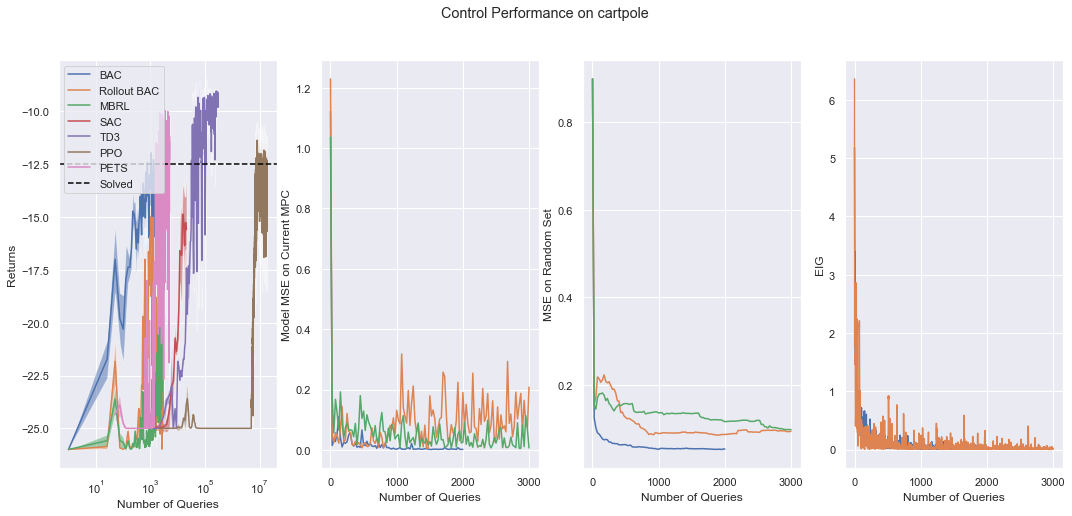

In [81]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)
    if plot_posterior_returns and 'Posterior Mean Returns' in vals:
        prmean = vals["Posterior Mean Returns"]
        prstderr = vals["Posterior Std Returns"]
        post_label = f'Posterior {key}'
        prnx = np.arange(prmean.shape[0])
        ax1.plot(prnx, prmean, label=post_label)
        ax1.fill_between(prnx, prmean - prstderr, prmean + prstderr, alpha=0.5)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
ax1.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")


BAC
(81,)
Rollout BAC
(121,)
MBRL
(121,)
SAC
(21,)
TD3
(300,)
PPO
(9100,)
PETS
(200,)


Text(0.5, 0.98, 'Control Performance on cartpole')

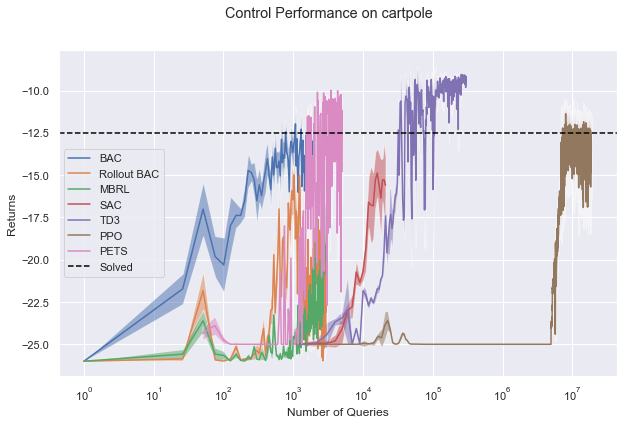

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    print(key)
    print(rmean.shape)
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if plot_posterior_returns and 'Posterior Mean Returns' in vals:
        prmean = vals["Posterior Mean Returns"]
        prstderr = vals["Posterior Std Returns"]
        post_label = f'Posterior {key}'
        prnx = np.arange(prmean.shape[0])
        ax.plot(prnx, prmean, label=post_label)
        ax.fill_between(prnx, prmean - prstderr, prmean + prstderr, alpha=0.5)
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax.legend()
ax.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")

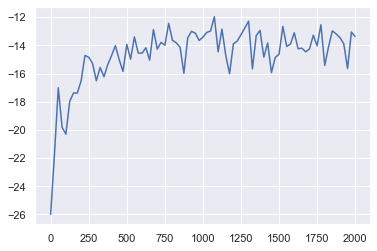

In [83]:
plt.plot(data['BAC']['Eval ndata'], np.mean(data['BAC']['Eval Returns'], axis=1))

In [84]:
np.mean(data['BAC']['Eval Returns'], axis=1)

array([-25.9999815 , -21.72301752, -17.00716553, -19.81633827,
       -20.30399336, -17.98392882, -17.38242125, -17.38379622,
       -16.52154142, -14.72297437, -14.84195152, -15.28143947,
       -16.51640251, -15.57088035, -16.22832385, -15.36302044,
       -14.72522329, -14.02536621, -15.01533153, -15.84706299,
       -13.92766754, -14.97796956, -13.40785658, -14.54557503,
       -14.55822754, -14.16952502, -15.04643718, -12.88149251,
       -14.2682315 , -13.7885351 , -13.99344662, -12.43943007,
       -13.64434443, -13.82031926, -14.14195074, -15.9859795 ,
       -13.47665985, -13.00647028, -13.13639972, -13.6523054 ,
       -13.42202191, -13.08612656, -12.98452266, -11.97071531,
       -14.45726225, -12.84931978, -14.72323898, -16.01633297,
       -13.89889088, -13.69843237, -13.24264702, -12.76894338,
       -12.28470316, -15.67146445, -13.31280737, -12.93944767,
       -14.83970269, -13.82933523, -15.93355327, -14.86324494,
       -14.6244019 , -12.65700767, -14.08059207, -13.90